# Bifurcation Point Identification with a LLM

## Oscillator Codes And Example Usage

In [3]:
# Classic python
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
from scipy.integrate import odeint # integrator
import scipy.io
import scipy
import textwrap
from scipy import sparse
import importlib
from itertools import product
import pickle  # saving outputs

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 7, 3

### Oscillator Types

In [4]:
def van_der_pol_oscillator(x, params):
    '''The famous equations'''
    dxdt = np.zeros(x.shape)
    dxdt[0] = x[1]
    dxdt[1] = params['mu'] * (1 - (x[0] * x[0])) * x[1] - x[0]
    return dxdt

def andronov_hopf_oscillator(x, params):
    '''Not sure where this comes from'''
    dxdt = np.zeros(x.shape)
    dxdt[0] = params['alpha'] * x[0] - x[1] - x[0] * (x[0]**2 + x[1]**2)
    dxdt[1] = x[0] + params['alpha'] * x[1] - x[1] * (x[0]**2 + x[1]**2)
    return dxdt

def hopf_normalForm_oscillator(z, params):
    '''Normal form of Hopf bifurcation from wikipedia'''
    lam  = params['lambda']
    b    = params['b']
    i    = params['i']
    dzdt = z * ((lam + i) + b * np.abs(z)**2)
    return dzdt

def lienard_oscillator(x, params):
    '''Not sure where this comes from'''
    dxdt = np.zeros(x.shape)
    dxdt[0] = x[1]
    dxdt[1] = -1*x[0] + (params['mu'] - x[0]**2)*x[1]
    return dxdt

def goodwin_oscillator_2var(x, params):
    """2 variable goodwin model from The Goodwin Oscillator and its Legacy"""
    dxdt = np.zeros(x.shape)
    dxdt[0] = params['alpha1'] * params['K'] / (params['K'] + x[1]) - params['delta1']
    dxdt[1] = params['alpha2'] * x[0] - params['delta2']
    return dxdt

def goodwin_oscillator_3var(x, params):
    """2 variable goodwin model from The Goodwin Revisited: Hopf bifurcation, limit-cycle, and periodic entrainment"""
    dxdt = np.zeros(x.shape)
    dxdt[0] = params['alpha'] / (1 + x[2]**params['n']) - x[0]
    dxdt[1] = x[0] - x[1]
    dxdt[2] = x[1] - x[2]
    return dxdt

def lotka_volterra_oscillator(x, params):
    """
    Calculate the derivative of prey and predator populations with respect to time for the Lotka-Volterra model.

    Parameters:
        x (array): Current state of the system, where x[0] represents the prey population and x[1] represents the predator population.
        params (dict): Dictionary containing the parameters of the system.
            'alpha' (float): Prey growth rate.
            'beta'  (float): Predation rate coefficient.
            'delta' (float): Predator reproduction rate.
            'gamma' (float): Predator death rate.

    Returns:
        dxdt (array): Derivative of prey and predator populations with respect to time.
    """
    alpha = params['alpha']
    beta  = params['beta']
    delta = params['delta']
    gamma = params['gamma']

    prey, predator = x
    prey_derivative = alpha * prey - beta * prey * predator
    predator_derivative = delta * prey * predator - gamma * predator

    dxdt = np.array([prey_derivative, predator_derivative])

    return dxdt

def repressilator_oscillator(x, params):
    '''Repressilator Oscillator from Elowitz's paper'''
    dxdt = np.zeros(x.shape)
    alpha_0 = params['alpha_0']
    alpha   = params['alpha']
    beta    = params['beta']
    n       = params['n']
    m_lacI, m_tetR, m_cl, p_lacI, p_tetR, p_cl = x
    dxdt[0] = -m_lacI + alpha_0 + alpha / (1 + p_cl**n)
    dxdt[1] = -m_tetR + alpha_0 + alpha / (1 + p_lacI**n)
    dxdt[2] = -m_cl + alpha_0 + alpha / (1 + p_tetR**n)
    dxdt[3] = -beta * p_lacI + beta * m_lacI
    dxdt[4] = -beta * p_tetR + beta * m_tetR
    dxdt[5] = -beta * p_cl + beta * m_cl
    return dxdt

def osc2data(osc):
    n = 2
    T = osc[0].traj.shape[1]
    reps = len(osc)
    data = np.zeros((n, T, reps))
    for i in range(len(osc)):
        data[:,:,i] = osc[i].traj
    return data

class oscillator:
    
    def __init__(self,x,params,cs,T=None,t=0,dt=0.01,otype='VDP'):
        self.type = otype
        self.x = x # state vector
        self.params = params # disctinary of parameters
        self.neighbors = []
        self.couplingStrength = cs
        self.traj = np.zeros((2,T))
        if otype == 'GW3':
            self.traj = np.zeros((3,T))
        if otype == 'REP':
            self.traj = np.zeros((6,T))
        self.traj[:,0] = self.x
        self.t = 0
        self.dt=dt
    
    def reset(self):
        self.t=0
    
    def update(self):
        # Van der pol
        if self.type == 'VDP':
            dxdt = van_der_pol_oscillator(self.x, self.params)
        elif self.type == 'AH':
            dxdt = andronov_hopf_oscillator(self.x, self.params)
        elif self.type == 'LD':
            dxdt = lienard_oscillator(self.x, self.params)
        elif self.type == 'GW2':
            dxdt = goodwin_oscillator_2var(self.x, self.params)
        elif self.type == 'GW3':
            dxdt = goodwin_oscillator_3var(self.x, self.params)
        elif self.type == 'REP':
            dxdt = repressilator_oscillator(self.x, self.params)
        elif self.type == 'LV':
            dxdt = lotka_volterra_oscillator(self.x, self.params)
        
        # diffusive term
        diffx = np.zeros(self.x.shape)
        for n in self.neighbors:
            diffx += (self.x - n.x)
        
        self.x += self.dt * (dxdt - self.couplingStrength * diffx)
        self.t += 1
        self.traj[:,self.t] = self.x
    
    def addNeighbors(self, N):
        self.neighbors.append(N)

### Example Usage

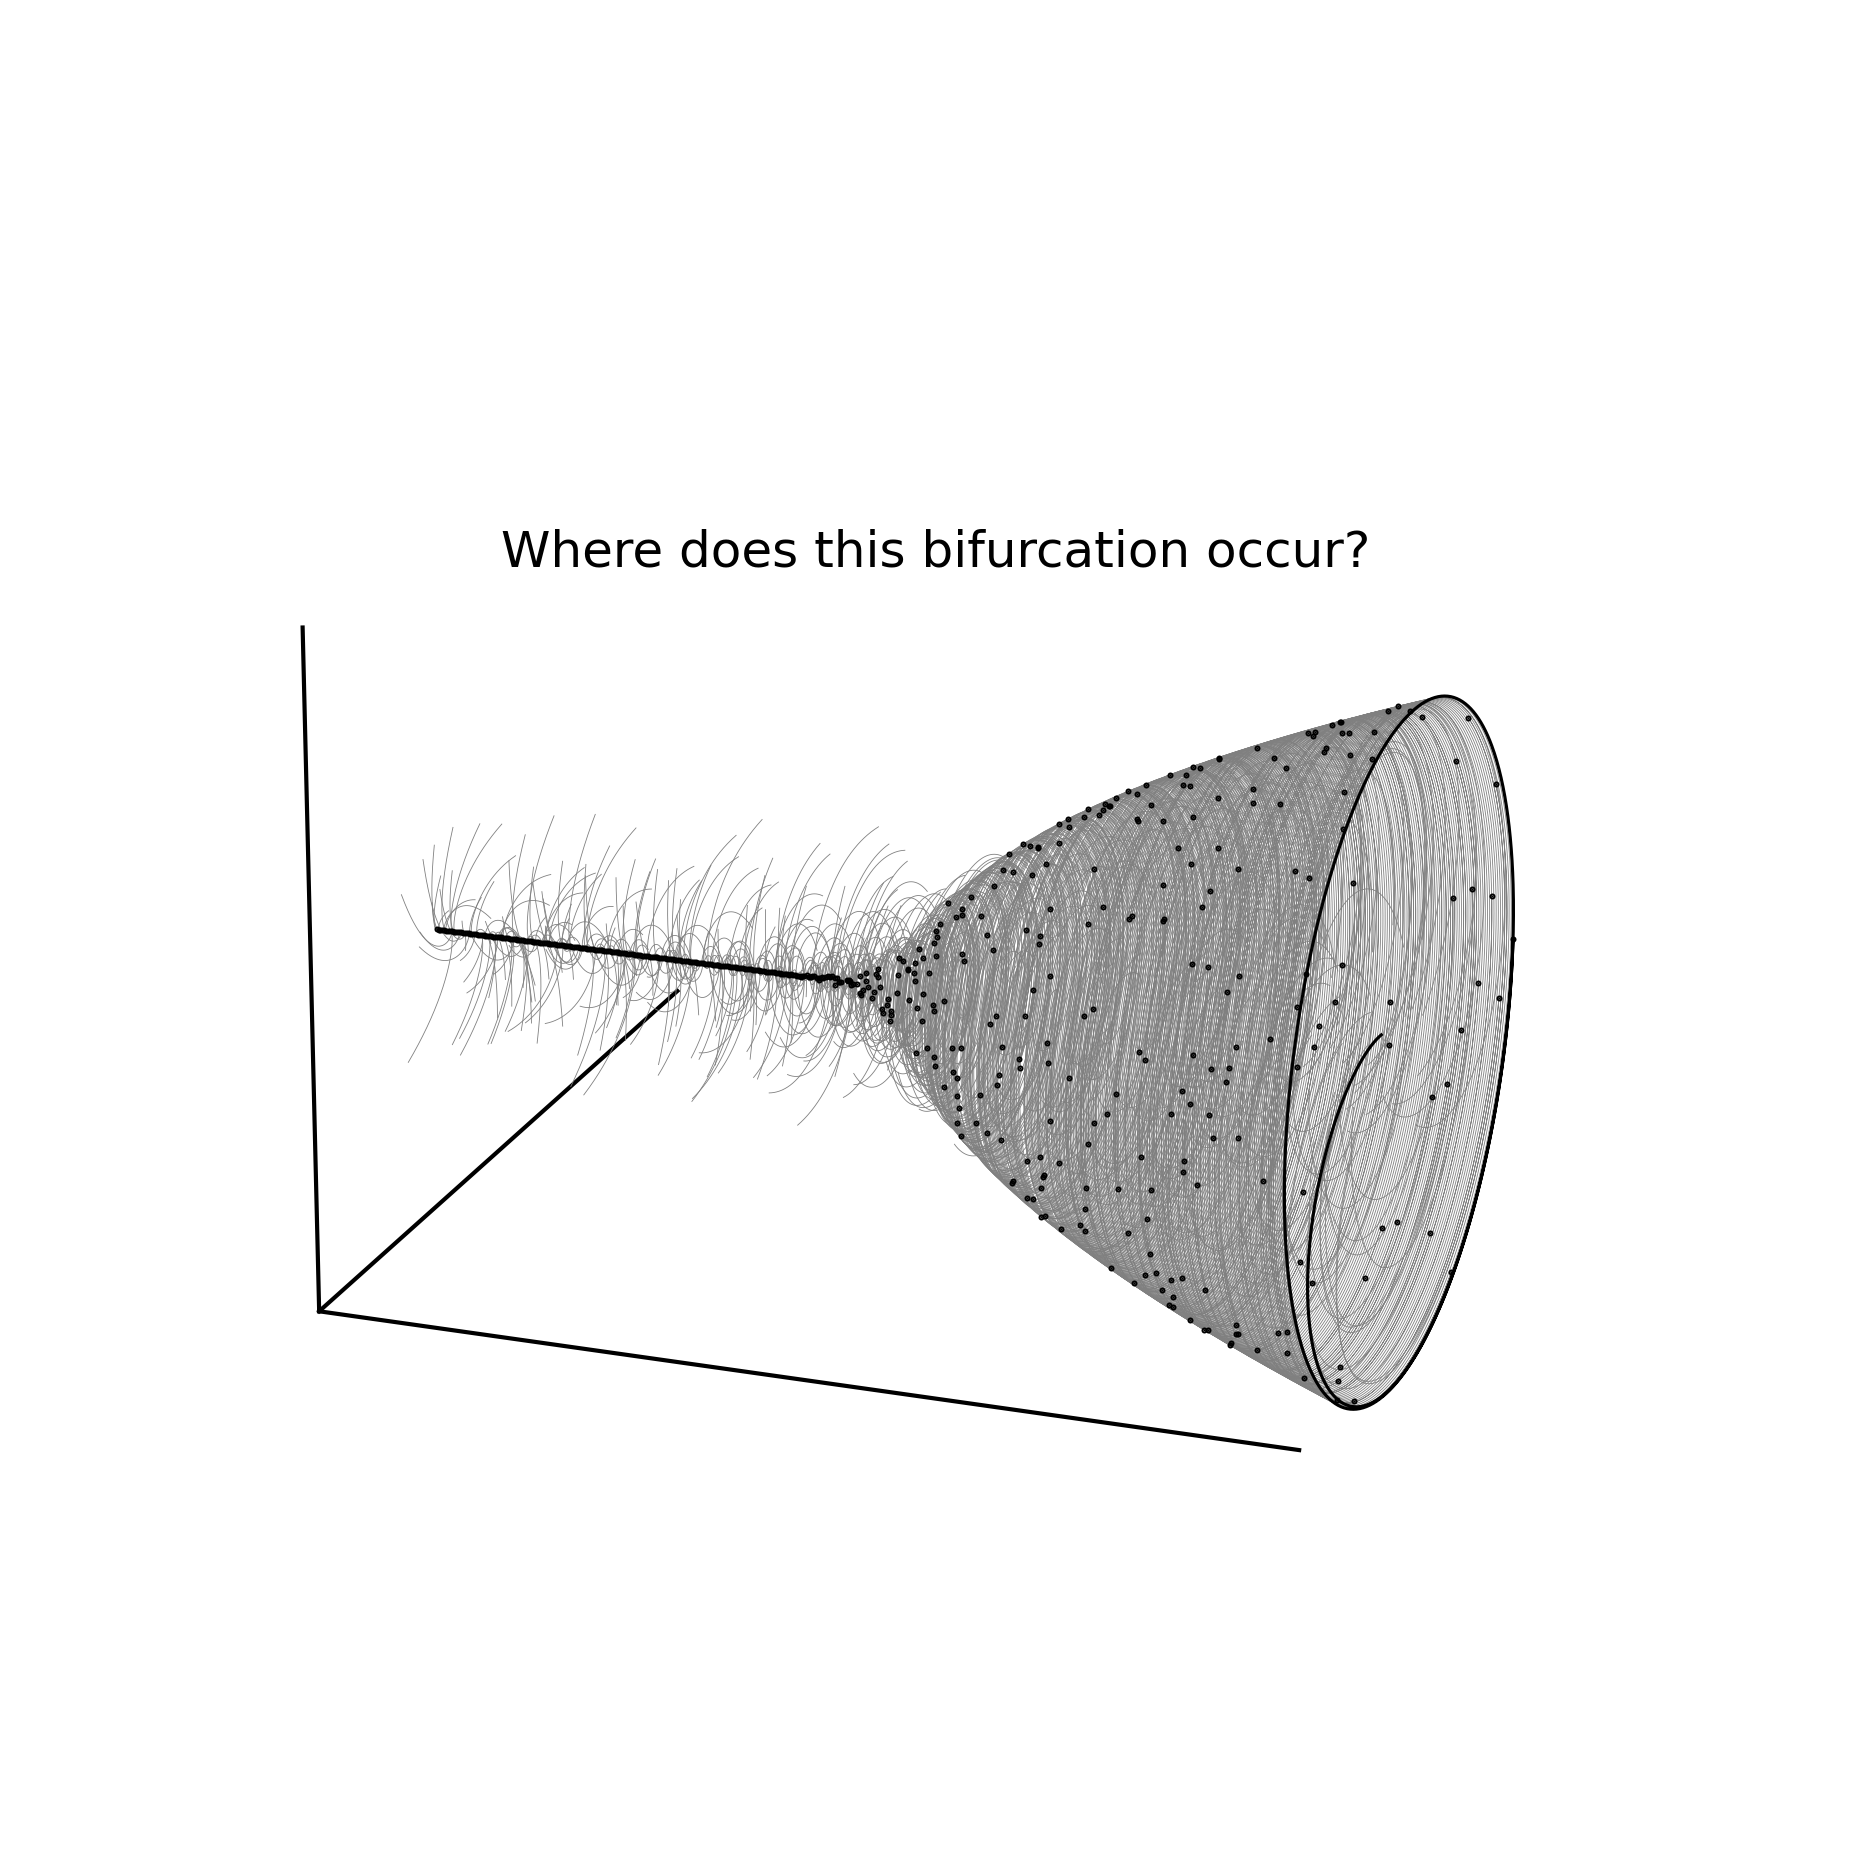

In [18]:
np.random.seed(0)
n = 500
cs = 0.0
T = 1000
osc = {}
params = {
    'alpha' : 0
}
alpha = np.arange(-2, 2, 4/n) # [-0.1, 0, 1]
for i in range(n):
    x = 1 * (np.random.rand(2,) - 0.5)
    params['alpha'] = alpha[i]
    O = oscillator(x, params.copy(), cs, T, otype='AH')
    osc[i] = O
        
for i in range(T-1):
    for k, v in osc.items():
        v.update()

x = np.zeros((n,T))
y = np.zeros((n,T))
z = np.zeros((n,T))
for k, v in osc.items():
    x[k,:] = v.traj[0,:]
    y[k,:] = v.traj[1,:]
    
fig = plt.figure(dpi=300, figsize=(10,8))
ax = fig.add_subplot(111, projection='3d') #, shading='off')
ax.plot([min(alpha), max(alpha)], [-1.2,-1.2], [-1.2,-1.2], color='k',    linewidth=1)
ax.plot([min(alpha), min(alpha)], [-1.2,-1.2], [-1.2, 1.7], color='k', linewidth=1)
ax.plot([min(alpha), min(alpha)], [-1.2, 2.5], [-1.2,-1.2], color='k',    linewidth=1)
for i in range(n):
    mu_vec = alpha[i] * np.ones_like(x[i,:])
    ax.scatter(mu_vec[0], x[i,-1], y[i,-1], color='k', s=0.2)
for i in range(n):
    mu_vec = alpha[i] * np.ones_like(x[i,:])
    ax.plot(mu_vec, x[i,:], y[i,:], color=(0.5,0.5,0.5), linewidth=0.2)
    if i == n-1:
        ax.plot(mu_vec, x[i,:], y[i,:], color='k', linewidth=0.75)
ax.axis('off')
ax.set_xlabel('Bifurcation Parameter')
ax.view_init(elev=20, azim=-70)
plt.title('Where does this bifurcation occur?', y=0.75)
plt.show()

# LLAMA Experiment

In [3]:
import numpy as np
import chromadb
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.output_parsers import CommaSeparatedListOutputParser
from semantic_router.layer import RouteLayer

#Extraction
import re
from nltk.corpus import words
from unidecode import unidecode
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package words to /home/jpic/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jpic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jpic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [1]:
import importlib
import chatbot
importlib.reload(chatbot)
from chatbot import *

/home/jpic/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jpic/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
[nltk_data] Downloading package words to /home/jpic/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jpic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jpic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
model_path = '/nfs/turbo/umms-indikar/shared/projects/RAG/models/llama-2-7b-chat.Q2_K.gguf' #llama-2-70b-orca-200k.Q3_K_S.gguf' #Meta-Llama-3-8B-Instruct-Q6_K.gguf.1' #llama-2-70b-orca-200k.Q3_K_S.gguf' #llama-2-7b-chat.Q2_K.gguf' # llama-2-7b-chat.Q8_0.gguf'
persist_directory = "/nfs/turbo/umms-indikar/shared/projects/RAG/databases/Transcription-Factors-5-10-2024/"
callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])
llm = LlamaCpp(model_path=model_path, n_ctx = 4098, n_gpu_layers=10, max_tokens = 4098, callback_manager=callback_manager, verbose=True)
ragvectordb, embeddings_model = load_literature_db(persist_directory)


llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /nfs/turbo/umms-indikar/shared/projects/RAG/models/llama-2-7b-chat.Q2_K.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:              

## Dicussion about experiment design with llama

In [6]:
prompt = "Can you help design an experiment?"
chain = load_qa_chain(llm, chain_type="stuff")
res = chain({"input_documents": [], "question": prompt})

 Sure! Before we can even think about designing an experiment, we need to identify what we want to test or measure. Can you tell me what you want to investigate or prove through this experiment?


llama_print_timings:        load time =    5168.67 ms
llama_print_timings:      sample time =      22.69 ms /    41 runs   (    0.55 ms per token,  1807.28 tokens per second)
llama_print_timings: prompt eval time =   21474.69 ms /    61 tokens (  352.04 ms per token,     2.84 tokens per second)
llama_print_timings:        eval time =    6618.09 ms /    40 runs   (  165.45 ms per token,     6.04 tokens per second)
llama_print_timings:       total time =   28287.50 ms /   101 tokens


In [7]:
prompt = "I have a dynamical system dx/dt=f(x,u), and I want to find the value of u that causes a bifurcation. We can generate data from this system if you give initial conditions x(0), u, and the amount of time we need to integrate the system forward, but it is very expensive to do so. We must propose an iterative scheme where you will make a hypothesis for the bifurcation value of u, propose an experiment, and analyse the data. What would you like to do?"
chain = load_qa_chain(llm, chain_type="stuff")
res = chain({"input_documents": [], "question": prompt})

Llama.generate: prefix-match hit



I think we should try to find the bifurcation value by numerically integrating the system forward in time with different initial conditions. We can use a small time step to make sure that we are not missing any important features of the dynamics, and we can also use a large number of initial conditions to increase our chances of finding the bifurcation value. I will propose an experiment where we start with many different initial conditions and integrate the system forward in time for a certain amount of time. We can then compare the resulting trajectories to see if any of them lead to a bifurcation event, and if so, what the bifurcation value is.
I don't know the answer.


llama_print_timings:        load time =    5168.67 ms
llama_print_timings:      sample time =      71.29 ms /   149 runs   (    0.48 ms per token,  2090.05 tokens per second)
llama_print_timings: prompt eval time =   36472.71 ms /   118 tokens (  309.09 ms per token,     3.24 tokens per second)
llama_print_timings:        eval time =   26604.40 ms /   148 runs   (  179.76 ms per token,     5.56 tokens per second)
llama_print_timings:       total time =   63718.57 ms /   266 tokens


In [8]:
prompt = "This is a good strategy, but it is very expensive to integrate this system and we want to minimize this cost. As a result, we cannot start with a large set of initial conditions and possible values for u, but we should instead start with only a few initial conditions and possible values of u. Based on these experiments, we will update our hypothesis and propose new values of u. We know a priori that the true value of u is between -5 and 5. After each experiment, how would you like to analyze the data or what information will you need from the integration results?"
chain = load_qa_chain(llm, chain_type="stuff")
res = chain({"input_documents": [], "question": prompt})

Llama.generate: prefix-match hit



I don't know the answer to this question, as it depends on the specific system being integrated and the available resources. However, I can suggest some general factors that might be considered when analyzing the results of experiments with a limited number of initial conditions and possible values of u:

* The accuracy of the new estimates of u compared to the original estimate (based on the prior distribution).
* The variability of the new estimates of u compared to the original estimate.
* The impact of the limited number of initial conditions and possible values of u on the precision of the estimates of u.
* The potential for bias in the estimates of u due to the limited sample size.
* The potential for overfitting or underfitting the data due to the limited number of initial conditions and possible values of u.
* The impact of any additional information that may be available, such as prior knowledge about the distribution of u or the results of previous experiments.
It is importa


llama_print_timings:        load time =    5168.67 ms
llama_print_timings:      sample time =     114.12 ms /   224 runs   (    0.51 ms per token,  1962.91 tokens per second)
llama_print_timings: prompt eval time =   48345.74 ms /   125 tokens (  386.77 ms per token,     2.59 tokens per second)
llama_print_timings:        eval time =   34082.24 ms /   223 runs   (  152.84 ms per token,     6.54 tokens per second)
llama_print_timings:       total time =   83404.65 ms /   348 tokens


In [9]:
prompt = "I will integrate the system based on your proposed parameters and initial conditions. What information from the integration (i.e. final state, speed, etc.) would you like me to provide you in order to detect a bifurcation?"
chain = load_qa_chain(llm, chain_type="stuff")
res = chain({"input_documents": [], "question": prompt})

Llama.generate: prefix-match hit


 To detect a bifurcation in the system during integration, I would need to know the following information about the system:
* The nature of the bifurcation (e.g. whether it is a Hodograph or Neimark bifurcation)
* The parameter values used for the integration (e.g. the values of the coefficients, the time step size, etc.)
* Any additional information that might be relevant to the bifurcation, such as the presence of symmetries or conservation laws.
I don't know the answer.


llama_print_timings:        load time =    5168.67 ms
llama_print_timings:      sample time =      66.43 ms /   120 runs   (    0.55 ms per token,  1806.30 tokens per second)
llama_print_timings: prompt eval time =   13215.77 ms /    53 tokens (  249.35 ms per token,     4.01 tokens per second)
llama_print_timings:        eval time =   18721.42 ms /   119 runs   (  157.32 ms per token,     6.36 tokens per second)
llama_print_timings:       total time =   32455.79 ms /   172 tokens


In [10]:
prompt = "You can propose different initial conditions and parameter values. I will integrate a differential equation. What information from the integrations (i.e. final state, speed, etc.) would you like me to provide you in order to detect the value where alpha causes a bifurcation?"
chain = load_qa_chain(llm, chain_type="stuff")
res = chain({"input_documents": [], "question": prompt})

Llama.generate: prefix-match hit



I would love to see the function that you are trying to solve and the initial conditions you used. This will help me understand how to analyze the problem better. Additionally, I would need to know what type of bifurcation you are looking for (e.g. transcritical or supercritical). Finally, please let me know what information you would like me to provide about the integration results.


llama_print_timings:        load time =    5168.67 ms
llama_print_timings:      sample time =      40.02 ms /    84 runs   (    0.48 ms per token,  2098.74 tokens per second)
llama_print_timings: prompt eval time =   19630.78 ms /    62 tokens (  316.63 ms per token,     3.16 tokens per second)
llama_print_timings:        eval time =   14271.35 ms /    83 runs   (  171.94 ms per token,     5.82 tokens per second)
llama_print_timings:       total time =   34262.33 ms /   145 tokens


# ChatGPT Guesses

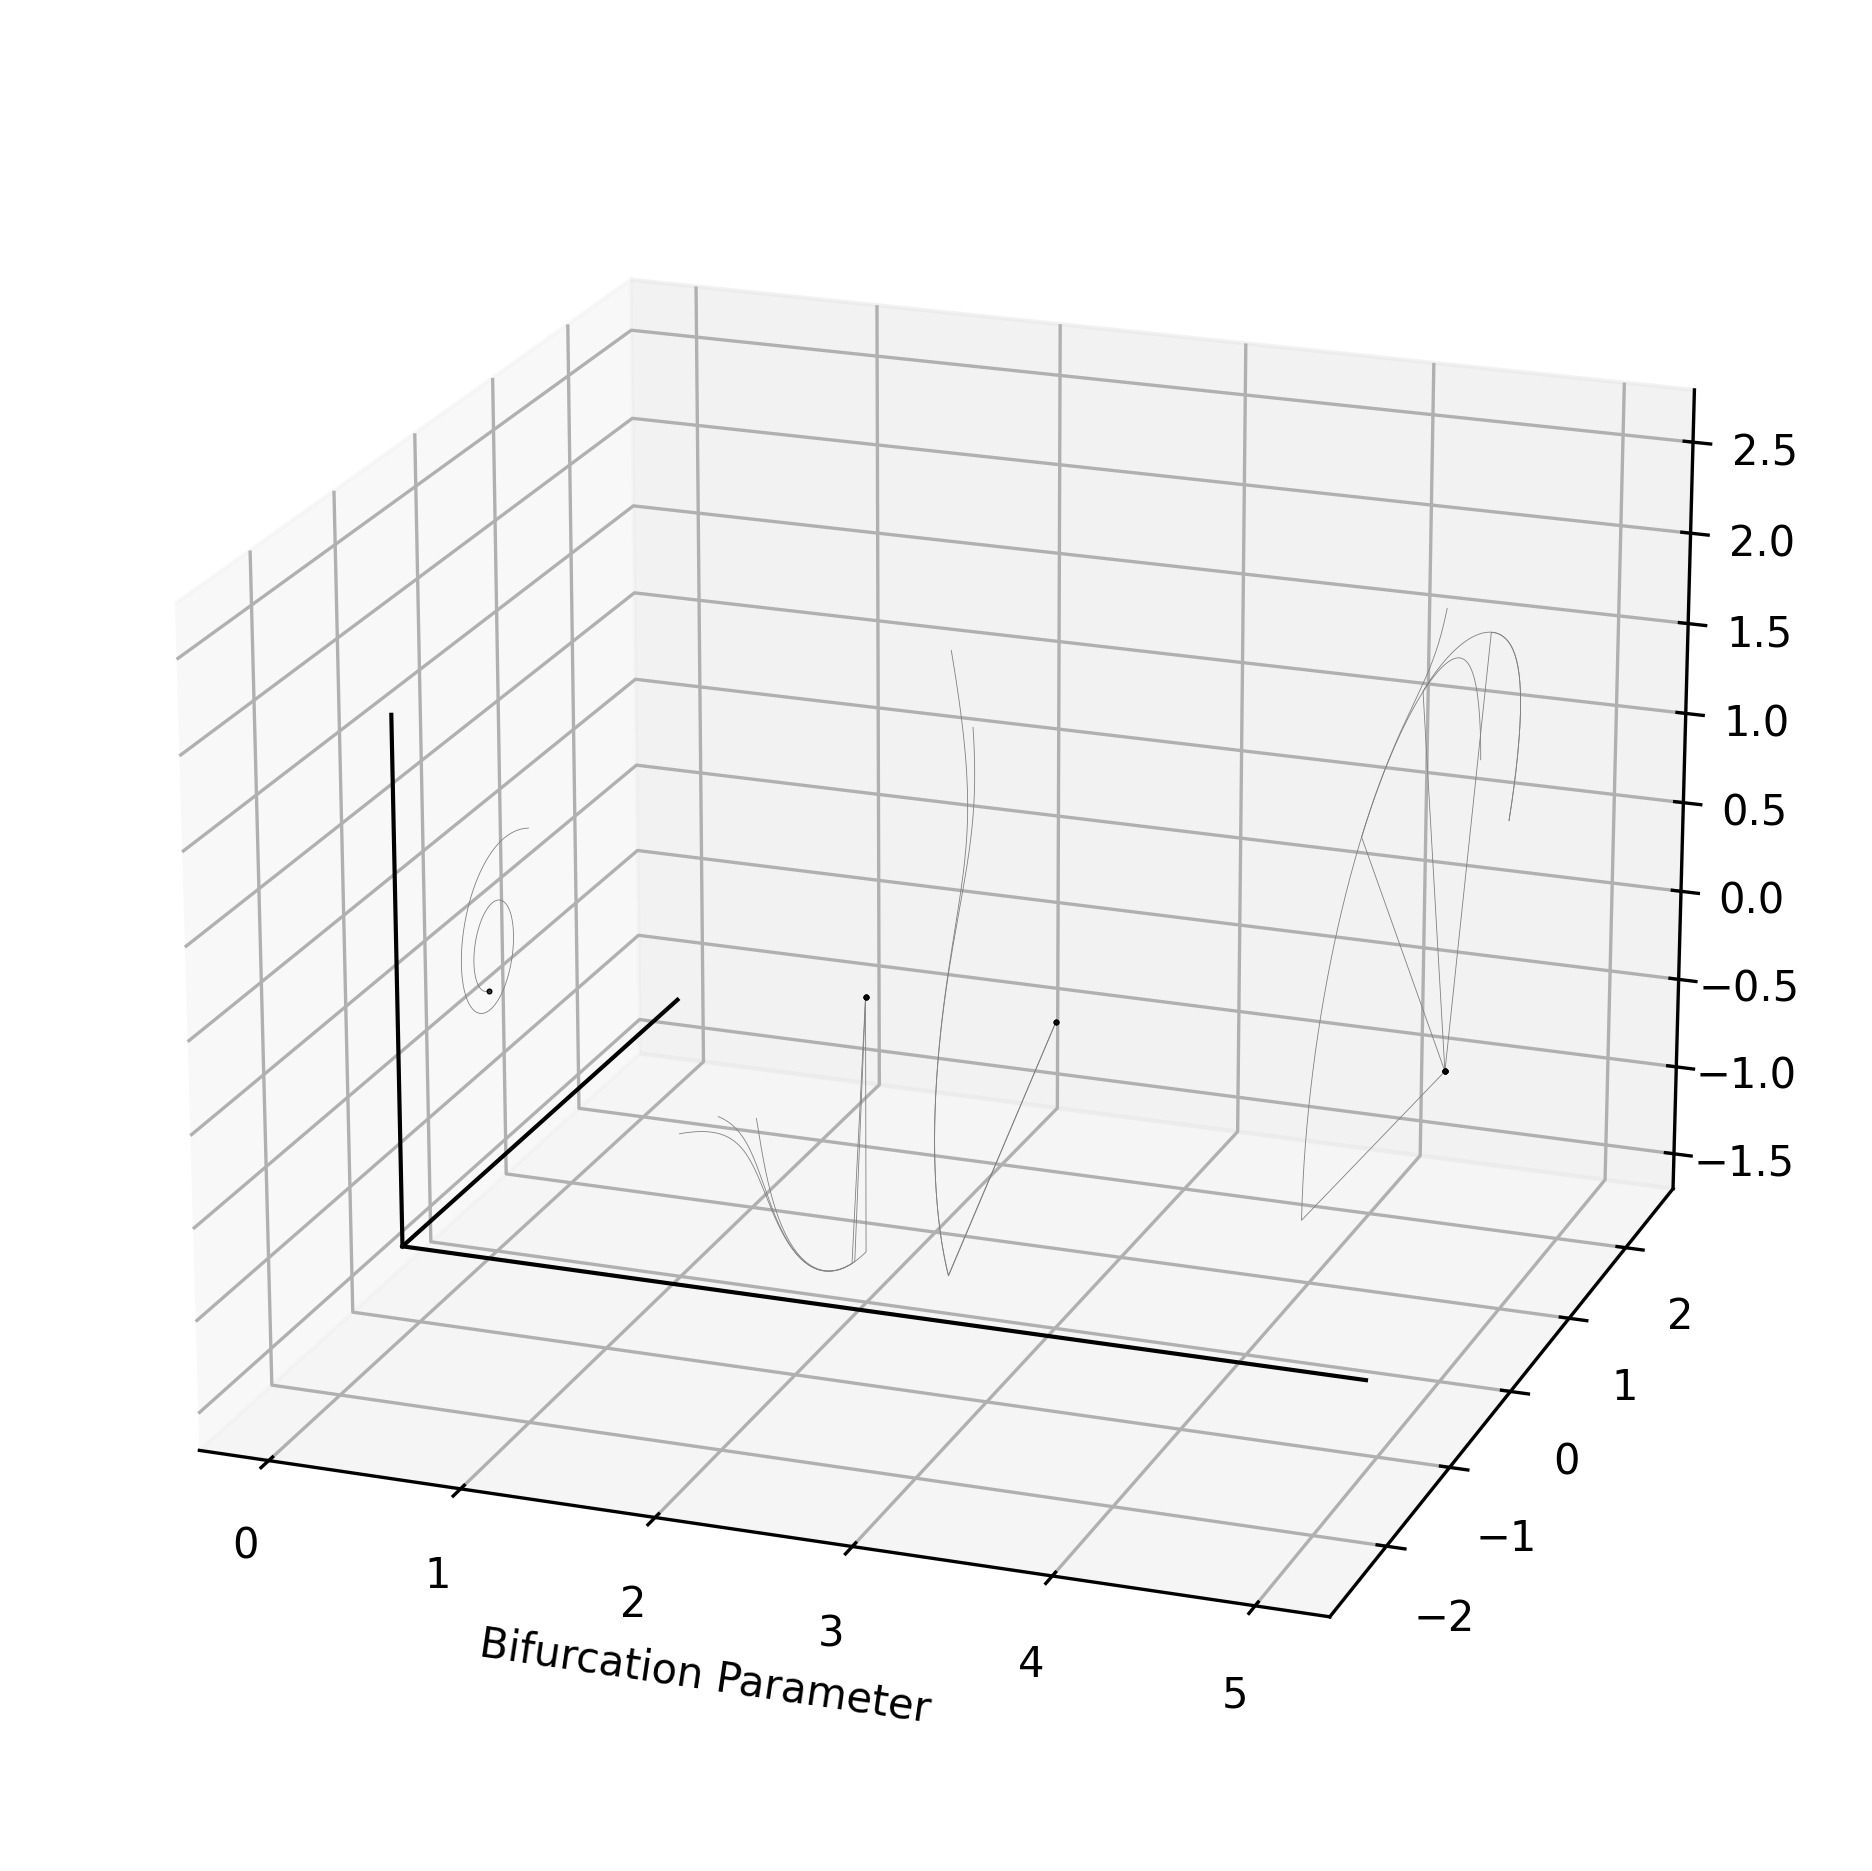

-0.0453, -0.214
0, 0
0.637, 2.13
-0.467, 2.19
-1.4, 1.75
-1.54, -0.789
-1.54, -0.793
-2.24, 0.0664
-0.166, -1.41
-0.205, -1.4
-0.00511, -1.42


In [23]:
np.random.seed(0)
n = 500
cs = 0.0
T = 1000
osc = {}
params = {
    'alpha' : 0
}
alpha = [0, 5, 5, 5, 5, 3, 3, 5, 2, 2, 2, 1, 1, 1]
ics   = [[0.5, 0.5],
         [0.0, 0.0],
         [1.0, 1.0],
         [1.0, 1.0],
         [0.5, 1.5],
         [-1.2,  2],
         [-1.5,2.5],
         [-0.1,2.5],
         [-2.0,0.1],
         [-2.5,0.2],
         [-1.5,-0.1]
]
times = [999, 50, 50, 100, 100, 150, 150, 150, 150, 150, 150, 150, 150, 150]
for i in range(len(alpha)):
    x = np.array([ics[i][0], ics[i][1]])
    params['alpha'] = alpha[i]
    O = oscillator(x, params.copy(), cs, T, otype='AH')
    osc[i] = O

j = 0
for k, v in osc.items():
    for i in range(times[j]):
        v.update()
    j += 1

x = np.zeros((n,T))
y = np.zeros((n,T))
z = np.zeros((n,T))
for k, v in osc.items():
    x[k,:] = v.traj[0,:]
    y[k,:] = v.traj[1,:]
                  
fig = plt.figure(dpi=300, figsize=(10,8))
ax = fig.add_subplot(111, projection='3d') #, shading='off')

ax.plot([min(alpha), max(alpha)], [-1.2,-1.2], [-1.2,-1.2], color='k',    linewidth=1)
ax.plot([min(alpha), min(alpha)], [-1.2,-1.2], [-1.2, 1.7], color='k', linewidth=1)
ax.plot([min(alpha), min(alpha)], [-1.2, 2.5], [-1.2,-1.2], color='k',    linewidth=1)
for i in range(len(alpha)):
    mu_vec = alpha[i] * np.ones_like(x[i,:])
    ax.scatter(mu_vec[0], x[i,-1], y[i,-1], color='k', s=0.2)
for i in range(len(alpha)):
    mu_vec = alpha[i] * np.ones_like(x[i,:])
    ax.plot(mu_vec, x[i,:], y[i,:], color=(0.5,0.5,0.5), linewidth=0.2)
    if i == n-1:
        ax.plot(mu_vec, x[i,:], y[i,:], color='k', linewidth=0.75)
ax.set_xlabel('Bifurcation Parameter')
ax.view_init(elev=20, azim=-70)
plt.show()

for t in range(len(times)):
    print(f"{x[t, times[t]]:.3g}, {y[t, times[t]]:.3g}")
